# Opdracht classificatie 1 - logistic regression

Logistische regressie is een bijzonder populaire classificatietechniek. Enerzijds door zijn eenvoud en relatief lage eisen die het stelt in termen van rekenkracht. In veel gevallen is de performantie qua accuracy vergelijkbaar (en soms beter) dan gecompliceerdere algoritmes zoals de support vector machines.
Daarnaast heeft logistische regressie het voordeel dat het getrainde model een voorspelling doet in termen van de kans dat de input tot een bepaalde klasse behoort. Uit deze kans kan je afleiden hoe overtuigd het model is van de gemaakte voorspelling.

Het is de bedoeling om via enkele classificatieopdrachten inzicht te verkrijgen in:
- Correct trainen en het uitvoeren van hyperparameter tuning bij logistische regressie.
- Classificaties kunnen uitvoeren via logistische regressie.
- Feature engineering uitvoeren.
- Weten wanneer je te maken hebt met overfitting en underfitting en de juiste bijstellingen kunnen doen.


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Opdracht 1: Classificatie van wijn

Het doel van deze classificatie is te kunnen achterhalen op basis van chemische parameters van welke wijnboer (cultivar) een wijn afkomstig is.

Gebruik hiervoor de dataset *wine_data.csv*. De features bevinden zich in de eerste kolommen van de dataset. De targets/outputs zijn in de laatste kolom te vinden.

### Inlezen van de dataset en vooranalyse

In [2]:
# inlezen van de data
wines = pd.read_csv('wine_data.csv')
wines.head(10)

,inputs Alcohol,MalicAcid,Ash,AlcalinityOfAsh,Magnesium,TotalPhenols,flavanoids,NonflavanoidsPhenols,Proanthocyanins,ColorIntensity,Hue,OD280/OD315,Proline,Cultivar
0,12.08,1.33,2.30,23.6,70,2.20,1.59,0.42,1.38,1.74,1.07,3.21,625,1
1,12.08,1.13,2.51,24.0,78,2.00,1.58,0.40,1.40,2.20,1.31,2.72,630,1
2,12.37,1.17,1.92,19.6,78,2.11,2.00,0.27,1.04,4.68,1.12,3.48,510,1
3,13.11,1.01,1.70,15.0,78,2.98,3.18,0.26,2.28,5.30,1.12,3.18,502,1
4,12.04,4.30,2.38,22.0,80,2.10,1.75,0.42,1.35,2.60,0.79,2.57,580,1
5,12.25,1.73,2.12,19.0,80,1.65,2.03,0.37,1.63,3.40,1.00,3.17,510,1
6,12.69,1.53,2.26,20.7,80,1.38,1.46,0.58,1.62,3.05,0.96,2.06,495,1
7,12.77,3.43,1.98,16.0,80,1.63,1.25,0.43,0.83,3.40,0.70,2.12,372,1
8,13.88,5.04,2.23,20.0,80,0.98,0.34,0.40,0.68,4.90,0.58,1.33,415,2
9,12.08,1.83,2.32,18.5,81,1.60,1.50,0.52,1.64,2.40,1.08,2.27,480,1


Bepaal het aantal klasses. Met andere woorden, hoeveel verschillende wijnboeren zijn er?

In [3]:
print(pd.value_counts(wines['Cultivar']))
print()
print('Het aantal klasses (of wijnboeren) bedraagt ', len(wines['Cultivar'].unique()))

1    71
0    59
2    48
Name: Cultivar, dtype: int64

Het aantal klasses (of wijnboeren) bedraagt  3


Hoeveel wijnen van elke wijnboer steken in de dataset? Is de dataset gebalanceerd? Gebalanceerd wil zeggen dat elke klasse ongeveer even sterk in de dataset aanwezig is.

In [4]:
dict = wines.groupby(['Cultivar']).groups

for key, value in dict.items():
    print('Wijnboer ', key, ' ==> ', len(value), ' wijnen')

Wijnboer  0  ==>  59  wijnen
Wijnboer  1  ==>  71  wijnen
Wijnboer  2  ==>  48  wijnen


Bepaal de statistische kerngetallen van de verschillende features en targets. Gebruik hiervoor de *describe* functie (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html). Gebruik de resultaten om na te gaan of er mogelijks ontbrekende waarden, uitschieters of onrealistische waarden zijn.

In [5]:
display(wines.describe())

,inputs Alcohol,MalicAcid,Ash,AlcalinityOfAsh,Magnesium,TotalPhenols,flavanoids,NonflavanoidsPhenols,Proanthocyanins,ColorIntensity,Hue,OD280/OD315,Proline,Cultivar
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


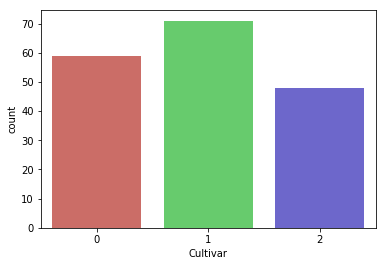

In [6]:
sns.countplot(x='Cultivar',data=wines, palette='hls')
plt.show()

Cultivar
0    [[AxesSubplot(0.125,0.725918;0.158163x0.154082...
1    [[AxesSubplot(0.125,0.725918;0.158163x0.154082...
2    [[AxesSubplot(0.125,0.725918;0.158163x0.154082...
dtype: object

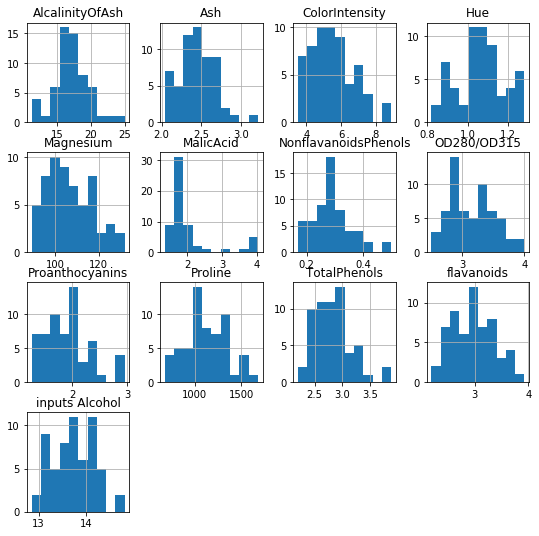

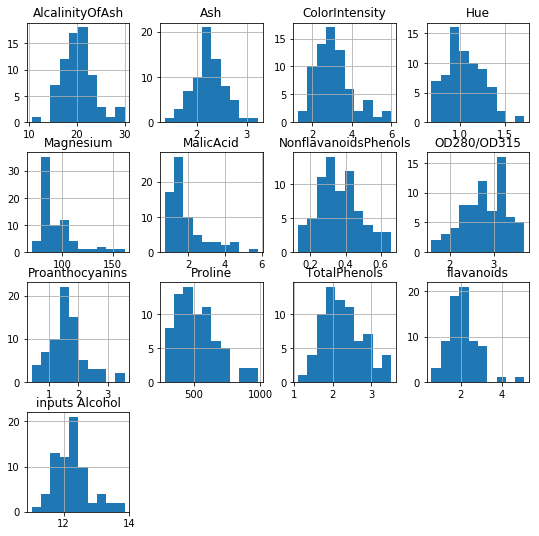

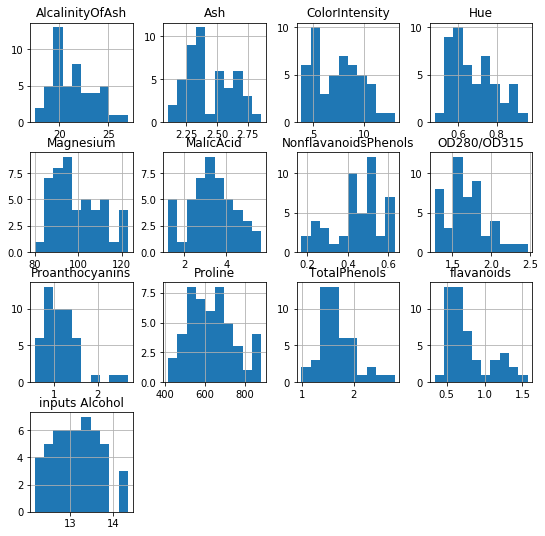

In [7]:
wines.groupby('Cultivar').hist(figsize=(9, 9))

In [8]:
wines.isnull().any()

inputs Alcohol          False
MalicAcid               False
Ash                     False
AlcalinityOfAsh         False
Magnesium               False
TotalPhenols            False
flavanoids              False
NonflavanoidsPhenols    False
Proanthocyanins         False
ColorIntensity          False
Hue                     False
OD280/OD315             False
Proline                 False
Cultivar                False
dtype: bool

In [9]:
#search for outliers
from scipy import stats
z = np.abs(stats.zscore(wines))
threshold = 3

outliers = len(wines) - len(wines[wines.sub(wines.mean()).div(wines.std()).abs() <= threshold].dropna())
print("records with outliers: ", outliers)

records with outliers:  10


In [10]:
wines = wines[(np.abs(stats.zscore(wines)) < 3).all(axis=1)]

### Preprocessing en opsplitsen van de dataset

Splits de dataset in **features en targets**.

In [11]:
features = list(wines.columns[:wines.columns.size-1])
X = wines[features].values 
y = wines['Cultivar'].values

**Normaliseer de dataset**. Zorg er dus voor dat de features op een gelijke schaalverdeling staan. Voor het normaliseren kan gebruik gemaakt worden van de *preprocessing.StandardScaler()*. Meer info over het gebruik ervan is te vinden op http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [12]:
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Creëer een **trainingset en een testset**. Zorg dat je 70 wijnen in de test set zitten hebt. Gebruik hiervoor train_test_split functie. Meer info is te vinden op http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=70, random_state=0)

### Trainen van een logistic regression classifier en testen van het bekomen model

Train een logistic regression classifier (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) op de training data. 
Kies C=1 als startwaarde. 

Test het getrainde model op de test set. Bepaal hierbij de confusion matrix, de accuracy en het classification report. Wat zijn de bevindingen?

Probeer indien nodig de performantie van de classifier te verhogen door de parameter C  aan te passen, class_weight aan te passen of een andere solver toe te passen. 
Schrijf de conclusies neer. 



In [14]:
logreg = linear_model.LogisticRegression()

# finetunen van model
param_grid = [{'C': np.logspace(-3,3,7), 'penalty': ['l1','l2'] }]

gs = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring='accuracy', cv=10)
gs = gs.fit(X_train, y_train)

print('Best Penalty:', gs.best_estimator_.get_params()['penalty'])
print('Best C:', gs.best_estimator_.get_params()['C'])
print('Accuracy :', gs.best_score_)

Best Penalty: l1
Best C: 0.1
Accuracy : 0.9897959183673469


In [15]:
gs.predict(X_test)

array([0, 1, 2, 2, 0, 0, 1, 1, 1, 0, 0, 0, 2, 0, 2, 2, 2, 1, 1, 1, 2, 0,
       0, 1, 1, 0, 2, 0, 0, 1, 2, 0, 2, 0, 0, 2, 1, 1, 0, 1, 0, 2, 0, 1,
       1, 2, 1, 0, 1, 1, 0, 0, 0, 2, 1, 2, 1, 2, 1, 1, 2, 0, 0, 1, 0, 1,
       1, 2, 0, 1])

In [16]:
#logreg = linear_model.LogisticRegression(C=0.1, random_state=0, penalty='l1')

# class_weight : dict or ‘balanced’, default: None
# Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one.
# The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).
# Note that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is specified.

# solver : str, {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default: ‘liblinear’.
# Algorithm to use in the optimization problem.
# - For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
# - For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
# - ‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas ‘liblinear’ and ‘saga’ handle L1 penalty.

logreg = linear_model.LogisticRegression(C=0.1, random_state=0, penalty='l2', class_weight= 'balanced', solver= 'newton-cg')

In [17]:
logreg.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

In [18]:
y_pred = logreg.predict(X_test)

In [19]:
print('confusion matrix')
print(confusion_matrix(y_test, y_pred))

confusion matrix
[[25  0  0]
 [ 0 27  2]
 [ 0  0 16]]


In [20]:
print('accuracy score')
print(accuracy_score(y_test, y_pred))

accuracy score
0.9714285714285714


In [21]:
print('classification report')
print(classification_report(y_test, y_pred))

classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      0.93      0.96        29
           2       0.89      1.00      0.94        16

   micro avg       0.97      0.97      0.97        70
   macro avg       0.96      0.98      0.97        70
weighted avg       0.97      0.97      0.97        70



### Voorspel aan de hand van het getrainde model

Voorspel van welke wijnboer een wijn afkomstig is met volgende samenstelling:

inputs Alcohol: 13.52 - 
MalicAcid: 2.05 - 
Ash: 2.20 - 
AlcalinityOfAsh: 17.3 - 
Magnesium: 120 - 
TotalPhenols: 2.60 - 
flavanoids: 3.52 - 
NonflavanoidsPhenols: 0.30 - 
Proanthocyanins: 2.28 - 
ColorIntensity: 7.80 - 
Hue: 0.77 - 
OD280/OD315: 2.90 - 
Proline: 862


Geef ook de overtuiging van het model weer dat de wijn van die bepaalde wijnboer afkomstig is.

In [22]:
print('Wijnboer: ', logreg.predict(np.array([13.52,2.05,2.20,17.3,120,2.60,3.52,0.30,2.28,7.80,0.77,2.90,862]).reshape(1,-1)))

print('Wijnboer 0/1/2', logreg.predict_proba(np.array([13.52,2.05,2.20,17.3,120,2.60,3.52,0.30,2.28,7.80,0.77,2.90,862]).reshape(1,-1)))

Wijnboer:  [0]
Wijnboer 0/1/2 [[1.00000000e+000 1.94686048e-264 2.52772279e-018]]


## Opdracht 2: Diabetes

Het bestand *diabetes.csv* bevat medische gegevens van meer dan 300 personen waarbij telkens geweten is of de persoon al dan niet diabetes heeft.
Train nu een logic regression model dat op basis van de features een zo goed mogelijke predictie kan doen of iemand al dan niet diabetes heeft.

### Inlezen van de dataset en vooranalyse

In [23]:
#Inlezen van de dataset
diabetes = pd.read_csv('diabetes.csv')
diabetes.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


Controleer of de dataset inconsistenties of foute waarden bevat. Gebruik listwise deletion. Dit betekent dat je alle gegevens van een persoon uit de dataset verwijdert van zodra er 1 feature foutief is of ontbreekt.

In [24]:
#check for nulls
diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [25]:
#check for outliers
from scipy import stats
z = np.abs(stats.zscore(diabetes))
threshold = 3

outliers = len(diabetes) - len(diabetes[diabetes.sub(diabetes.mean()).div(diabetes.std()).abs() <= threshold].dropna())
print("records with outliers: ", outliers)

records with outliers:  80


In [26]:
diabetes = diabetes[(np.abs(stats.zscore(diabetes)) < 3).all(axis=1)]

In [27]:
print('(rows, cols)', diabetes.shape)

(rows, cols) (688, 9)


In [28]:
print("dimension of diabetes data: {}".format(diabetes.shape))

dimension of diabetes data: (688, 9)


In [29]:
correlations = diabetes.corr()
correlations['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.478614
BMI                         0.298056
Age                         0.246290
Pregnancies                 0.226382
DiabetesPedigreeFunction    0.213872
BloodPressure               0.182521
Insulin                     0.110062
SkinThickness               0.056662
Name: Outcome, dtype: float64

In [30]:
#replace 0 by NaN
import numpy
diabetes[['Glucose','BloodPressure','SkinThickness','BMI','DiabetesPedigreeFunction','Age']] = diabetes[['Glucose','BloodPressure','SkinThickness','BMI','DiabetesPedigreeFunction','Age']].replace(0, numpy.NaN)
#remove rows with NaN
diabetes.dropna(inplace=True)

In [31]:
print('(rows, cols)', diabetes.shape)

(rows, cols) (498, 9)


Bepaal de verdeling van het aantal personen met diabetes ten opzichte van het aantal personen zonder. Is de dataset gebalanceerd?

In [32]:
hasCount = (diabetes['Outcome'] == 1).sum()
hasNotCount = (diabetes['Outcome'] == 0).sum()

print('geen diabetes = ', hasNotCount)
print('diabetes = ', hasCount)

if hasCount != hasNotCount:
    print('niet gebalanceerd')
else:
    print('gebalanceerd')


geen diabetes =  343
diabetes =  155
niet gebalanceerd


In [33]:
print(diabetes.groupby('Outcome').size())

Outcome
0    343
1    155
dtype: int64


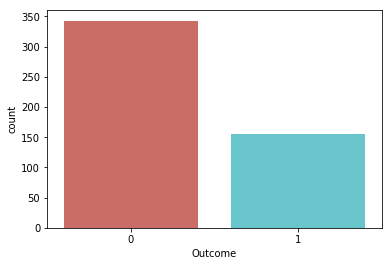

In [34]:
sns.countplot(x='Outcome',data=diabetes, palette='hls')
plt.show()

Outcome
0    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
1    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
dtype: object

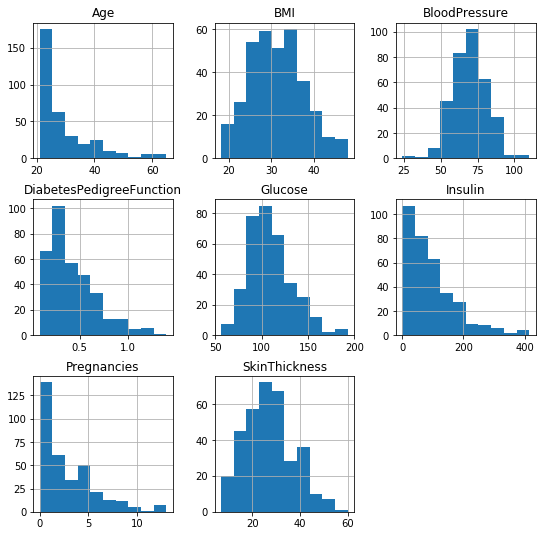

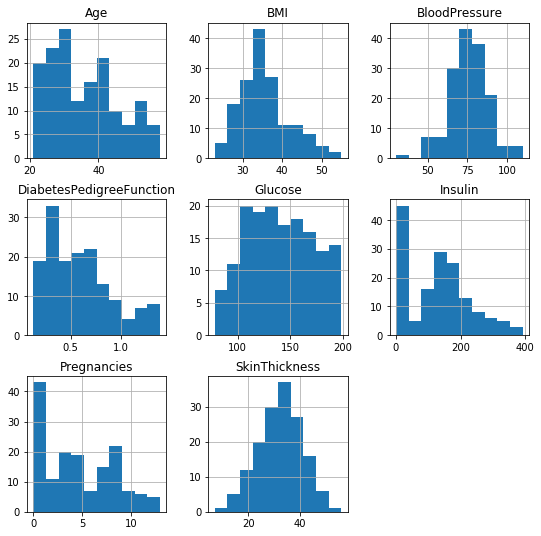

In [35]:
diabetes.groupby('Outcome').hist(figsize=(9, 9))

Bepaal de statistische kerngetallen van de verschillende features en target. Gebruik hiervoor de *describe* functie.

In [36]:
display(diabetes.describe())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000
mean,3.459839,118.845382,71.403614,28.718876,100.170683,32.567470,0.479014,31.234940,0.311245
std,3.183110,29.868090,12.193764,9.991208,91.905192,6.525112,0.288248,10.236785,0.463468
min,0.000000,56.000000,24.000000,7.000000,0.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,97.000000,64.000000,21.000000,0.000000,27.800000,0.259000,23.000000,0.000000
50%,2.000000,112.000000,72.000000,29.000000,87.500000,32.600000,0.407500,28.000000,0.000000
75%,5.000000,137.000000,80.000000,36.000000,155.750000,36.575000,0.646750,37.000000,1.000000
max,13.000000,199.000000,110.000000,60.000000,415.000000,55.000000,1.400000,65.000000,1.000000


### Preprocessing en opsplitsen van de dataset

Splits de dataset in **features en targets**.

In [37]:
features = list(diabetes.columns[:diabetes.columns.size-1])
X = diabetes[features].values 
y = diabetes['Outcome'].values

**Normaliseer de dataset**. Zorg er dus voor dat de features op een gelijke schaalverdeling staan. Voor het normaliseren kan gebruik gemaakt worden van de *preprocessing.StandardScaler()*. Meer info over het gebruik ervan is te vinden op http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [38]:
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Creëer een **trainingset en een testset**. Zorg dat er 100 patiënten in de testset steken. 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=0)

## Normaliseren van de training set en de test set
#from sklearn.preprocessing import StandardScaler
#scaler = preprocessing.StandardScaler()
#scaler.fit(X_train)

#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

### Trainen van een logistic regression classifier en testen van het bekomen model

Train een logistic regression classifier op de training data. Kies C=1 als startwaarde. Mocht de dataset niet gebalanceerd zijn (de ene klasse komt frequenter voor dan de andere klasse) dan kan je bij de creatie van het logistic regression model de parameter class_weight='balanced' meegeven. Meer info: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Test het getrainde model op de test set. Bepaal hierbij de confusion matrix, de accuracy en het classification report. Wat zijn de bevindingen? Probeer ook verschillende solvers uit.

Probeer de performantie van de classifier te verhogen door de parameter C te veranderen.

In [40]:
logreg = linear_model.LogisticRegression()

# finetunen van model
param_grid = [{'C': [1, 10, 50, 100, 500, 1000], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] }]

gs = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring='accuracy', cv=50, verbose=0)
gs = gs.fit(X_train, y_train)

print('Best Penalty:', gs.best_estimator_.get_params()['penalty'])
print('Best C:', gs.best_estimator_.get_params()['C'])
print('Best solver :', gs.best_estimator_.get_params()['solver'])
print('Accuracy :', gs.best_score_)

Best Penalty: l2
Best C: 1
Best solver : liblinear
Accuracy : 0.7889447236180904


In [41]:
gs.predict(X_test)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

In [42]:
logreg = linear_model.LogisticRegression(C=0.1, random_state=0, penalty='l1')
logreg.fit(X_train,y_train)
print('C=0.1, l1')
print("Training set accuracy: {:.3f}".format(logreg.score(X_train, y_train.ravel())))
print("Test set accuracy: {:.3f}".format(logreg.score(X_test, y_test)))

C=0.1, l1
Training set accuracy: 0.812
Test set accuracy: 0.810


In [43]:
logreg = linear_model.LogisticRegression(C=0.1, random_state=0, penalty='l1', class_weight= 'balanced')
logreg.fit(X_train,y_train)
print('C=0.1, l1, balanced')
print("Training set accuracy: {:.3f}".format(logreg.score(X_train, y_train.ravel())))
print("Test set accuracy: {:.3f}".format(logreg.score(X_test, y_test)))

C=0.1, l1, balanced
Training set accuracy: 0.784
Test set accuracy: 0.750


In [44]:
logreg = linear_model.LogisticRegression(C=1, random_state=0, penalty='l1', class_weight= 'balanced')
logreg.fit(X_train,y_train)
print('C=1, l1, balanced')
print("Training set accuracy: {:.3f}".format(logreg.score(X_train, y_train.ravel())))
print("Test set accuracy: {:.3f}".format(logreg.score(X_test, y_test)))

C=1, l1, balanced
Training set accuracy: 0.781
Test set accuracy: 0.770


In [45]:
logreg = linear_model.LogisticRegression(C=100, random_state=0, penalty='l1', class_weight= 'balanced')
logreg.fit(X_train,y_train)
print('C=100, l1, balanced')
print("Training set accuracy: {:.3f}".format(logreg.score(X_train, y_train.ravel())))
print("Test set accuracy: {:.3f}".format(logreg.score(X_test, y_test)))

C=100, l1, balanced
Training set accuracy: 0.779
Test set accuracy: 0.770


In [46]:
logreg = linear_model.LogisticRegression(C=1, random_state=0, penalty='l2', class_weight= 'balanced')
logreg.fit(X_train,y_train)
print('C=1, l2, balanced')
print("Training set accuracy: {:.3f}".format(logreg.score(X_train, y_train.ravel())))
print("Test set accuracy: {:.3f}".format(logreg.score(X_test, y_test)))

C=1, l2, balanced
Training set accuracy: 0.779
Test set accuracy: 0.780


In [47]:
logreg = linear_model.LogisticRegression(C=1, random_state=0, penalty='l2', class_weight= 'balanced', solver= 'liblinear')
logreg.fit(X_train,y_train)
print('C=1, l2, balanced, liblinear')
print("Training set accuracy: {:.3f}".format(logreg.score(X_train, y_train.ravel())))
print("Test set accuracy: {:.3f}".format(logreg.score(X_test, y_test)))

C=1, l2, balanced, liblinear
Training set accuracy: 0.779
Test set accuracy: 0.780


In [48]:
logreg = linear_model.LogisticRegression(C=0.001, random_state=0, penalty='l2', class_weight= 'balanced', solver= 'liblinear')
logreg.fit(X_train,y_train)
print('C=0.001, l2, balanced, liblinear')
print("Training set accuracy: {:.3f}".format(logreg.score(X_train, y_train.ravel())))
print("Test set accuracy: {:.3f}".format(logreg.score(X_test, y_test)))

C=0.001, l2, balanced, liblinear
Training set accuracy: 0.729
Test set accuracy: 0.730


In [49]:
logreg = linear_model.LogisticRegression(C=100, random_state=0, penalty='l2', class_weight= 'balanced', solver= 'liblinear')
logreg.fit(X_train,y_train)
print('C=100, l2, balanced, liblinear')
print("Training set accuracy: {:.3f}".format(logreg.score(X_train, y_train.ravel())))
print("Test set accuracy: {:.3f}".format(logreg.score(X_test, y_test)))

C=100, l2, balanced, liblinear
Training set accuracy: 0.779
Test set accuracy: 0.770


In [50]:
#final
logreg = linear_model.LogisticRegression(C=1, random_state=0, penalty='l2', class_weight= 'balanced', solver= 'liblinear')
logreg.fit(X_train,y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [51]:
y_pred = logreg.predict(X_test)

In [52]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print('confusion matrix')
print(cnf_matrix)

confusion matrix
[[56 11]
 [11 22]]


Text(0.5, 257.44, 'Predicted label')

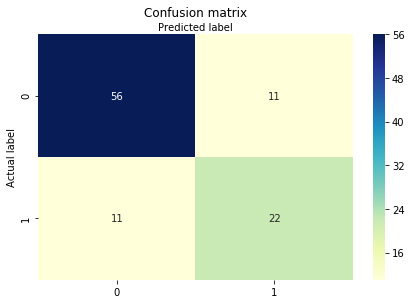

In [53]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [54]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.78
Precision: 0.6666666666666666
Recall: 0.6666666666666666


In [55]:
print('classification report')
print(classification_report(y_test, y_pred))

classification report
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        67
           1       0.67      0.67      0.67        33

   micro avg       0.78      0.78      0.78       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.78      0.78      0.78       100



### Feature engineering
Creeër hogere orde features door gebruik te maken van *preprocessing.PolynomialFeatures*. Meer info is te vinden op http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

Deze functie zal automatische hogere orde features aanmaken door het combineren van de aanwezige features. Heb je bijvoorbeeld drie features, zijnde A, B en C dan worden bij de keuze van een derde orde PolynomialFeatures volgende nieuwe features bijgemaakt:
$A^3, B^3,C^3,A^2B,A^2C,AB^2, B^2C,...$

Experimenteer met verschillende ordes en gebruik de regularisatieparameter C om de performantie te verhogen.

**Opgepast**: het kiezen van een te hoge orde zorgt voor een exponentiële toename aan features waardoor de logistic regression classifier niet meer binnen aanvaardbare tijd getraind kan worden. Advies is om niet hoger te gaan dan 4de orde.

In [56]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV

degree_min = 1
degree_max = 4

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=100, random_state=0)

for degree in range(degree_min, degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), linear_model.LogisticRegression(C=1.0, random_state=0, penalty='l2', class_weight= 'balanced', solver= 'newton-cg'))
    model.fit(X_train2, y_train2)    
        
    print('degree: ', degree)
    print("Training set accuracy: {:.3f}".format(model.score(X_train2, y_train2)))
    print("Test set accuracy: {:.3f}".format(model.score(X_test2, y_test2)))    
    print()        

degree:  1
Training set accuracy: 0.779
Test set accuracy: 0.780

degree:  2
Training set accuracy: 0.799
Test set accuracy: 0.710

degree:  3
Training set accuracy: 0.910
Test set accuracy: 0.750

degree:  4
Training set accuracy: 0.995
Test set accuracy: 0.710



Wat zijn de bevindingen? Formuleer een conclusie. Bespreek hierin de performantie van de getrainde modellen. Wat is de invloed van de parameter C en van het aantal features? Heb je te maken gehad met underfitting en overfitting en hoe heb je dit bepaald? Welke accuracy werd bekomen en hoe zit het met de Recall en Precision? Is de grootte van de trainingset voldoende?

_Precision_: als het model voorspelt dat een persoon diabetes heeft, is dat correct in 66% van de gevallen

_Recall_: als er personen in de testset zijn met diabetes, dan kan het model in 66% van de gevallen dat detecteren

* Toevoegen van 2de graad features
    * score op trainingsdata stijgt, maar score op testdata daalt
* Toevoegen van 3de graad features
    * score op trainingsdata stijgt, maar score op testdata daalt
* Toevoegen van 4de graad features
    * score op trainingsdata stijgt, maar score op testdata daalt

Te weinig (en onvolledige) data, niet gebalanceerd.

### Voorspel aan de hand van het getrainde model

Voorspel of iemand met onderstaande medische parameters als dan niet diabetes heeft. Geef ook de zekerheid van het model weer (kansen dat de patiënt tot een bepaalde klasse behoort).

Pregnancies: 2 -
Glucose: 132 -
BloodPressure: 74 - 
SkinThickness: 20 - 
Insulin: 21 - 
BMI: 24.3 - 
DiabetesPedigreeFunction: 128 - 
Age: 37

In [57]:
print('Diabetes: ', logreg.predict(np.array([2,132,74,20,21,24.3,128,37]).reshape(1,-1)))
print('Diabetes 0/1', logreg.predict_proba(np.array([2,132,74,20,21,24.3,128,37]).reshape(1,-1)))

Diabetes:  [1]
Diabetes 0/1 [[0. 1.]]


## Opdracht 3: Kankerdetectie

Train een model om te voorspellen of een bepaalde tumor goedaardig (benign) of kwaadaardig (malignant) is.
Gebruik daarvoor de dataset '*cancer.csv*'

Baseer je op de methodieken uit voorgaande opdrachten om tot een zo goed mogelijk resultaat te komen. 
**Bespreek** telkens de gemaakte keuzes en resultaten en kom tot een duidelijk besluit.

Tip: een classifier kan enkel maar getraind worden met numerieke waarden. Vervang daarom bij de feature diagnose de twee klasses die voorkomen door 0 en 1, waarbij 0 staat voor goedaardig en 1 voor kwaadaardig.


Voorspel of een gezwel met onderstaande parameters goedaardig of kwaadaardig is.

radius_mean: 17.99 |
texture_mean: 10.38 |
perimeter_mean: 122.8 |
area_mean: 1001 |
smoothness_mean: 0.1184 |
compactness_mean: 0.2776 |
concavity_mean: 0.3001 |
concave points_mean: 0.1471 |
symmetry_mean: 0.2419 |
fractal_dimension_mean: 0.07871 |
radius_se: 1.095 |
texture_se: 0.9053 |
perimeter_se: 8.589 |
area_se:153.4 |
smoothness_se:0.006399 |
compactness_se: 0.04904 |
concavity_se: 0.05373 |
concave points_se: 0.01587 |
symmetry_se: 0.03003 |
fractal_dimension_se: 0.006193 |
radius_worst: 25.38 |
texture_worst: 17.33 |
perimeter_worst: 184.6 |
area_worst: 2019 |
smoothness_worst: 0.1622 |
compactness_worst: 0.6656 |
concavity_worst: 0.7119 |
concave points_worst: 0.2654 |
symmetry_worst: 0.4601 |
fractal_dimension_worst: 0.1189 |
